In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # Add parent directory to path

/Users/luisvalenzuela/Documents/Programs/Memoria/data/processed/image_2_label_0/ms/image_2_label_0.alma.out08.ms


2025-06-24 14:23:37	WARN	task_tclean::SIImageStore::restore (file /Users/casaci/bamboohome/xml-data/build-dir/CASASPECS-RELEASE670BUILDCASALITH0-BPOSX14ARMPY310/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2298)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


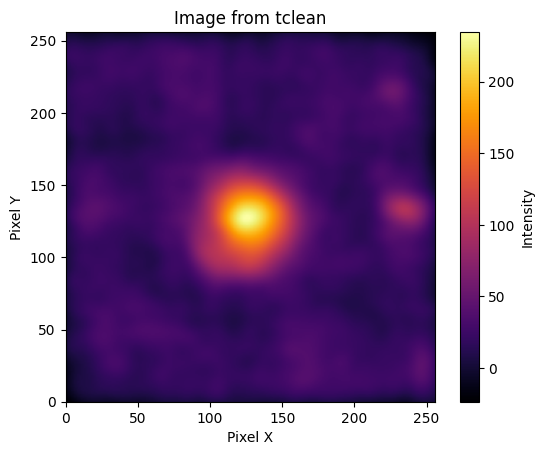

In [ ]:
# Show the dirty image of a ms
from src.preprocess.imager import Imager
from src.utils.plot import plot_image

image_folder = '../data/processed/image_2_label_0/'
ms_path = os.path.join(image_folder, 'ms')
ms_file = os.listdir(ms_path)[0]

ms_full_path = os.path.join(ms_path, ms_file)

imager = Imager(vis = ms_full_path, output_path=image_folder)

niter = 0
tclean_config = {
    'imsize': 256,
    'cell': '0.04arcsec',
    'niter': niter,
    'weighting': 'natural',
}

print(imager.vis)
imager.tclean(config=tclean_config)

plot_image(image_path=os.path.join(image_folder, f'tclean_{niter}', f'tclean_{niter}.image'), title='Image from tclean')

In [ ]:
# gpuvmem_config = {
#     '': 0,
# }
# imager.gpuvmem(config=gpuvmem_config)

SNR: -5.751857340486444
SSIM: 0.33770407264979246
PSNR: 21.277818975589543


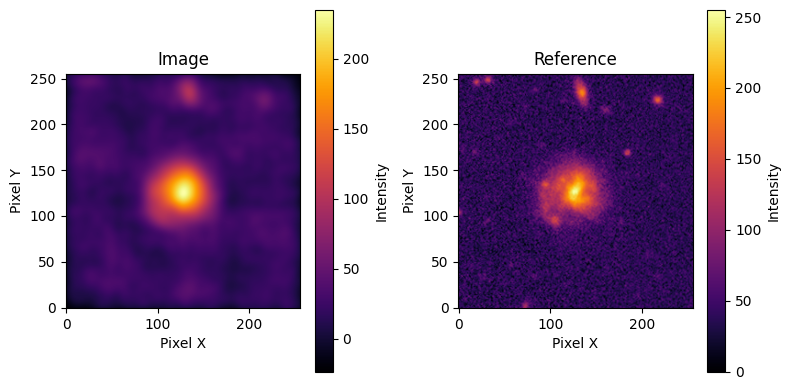

In [ ]:
# Calculate image quality metrics of the dirty image
from src.preprocess.image_quality_metrics import ImageQualityMetrics

image_path = os.path.join(image_folder, f'tclean_{niter}', f'tclean_{niter}.image')
reference_folder = os.path.join(image_folder, 'groundtruth')
reference_image = os.listdir(reference_folder)[0]
reference_path = os.path.join(reference_folder, reference_image)

iqm = ImageQualityMetrics(image_path=image_path, reference_path=reference_path)
snr = iqm.calculate_snr()
ssim = iqm.calculate_ssim()
psnr = iqm.calculate_psnr()

iqm.plot_images()

print(f'SNR: {snr}')
print(f'SSIM: {ssim}')
print(f'PSNR: {psnr}')

In [ ]:
# Delete existing cleaned images
import shutil

data_folder = "../data/processed"
file_folder = 'image_2_label_0'

image_folder = os.path.join(data_folder, file_folder)
list_dir = os.listdir(image_folder)

for d in list_dir:
    if 'tclean' in d:
        shutil.rmtree(os.path.join(image_folder, d))

In [ ]:
# Calculate image quality metrics for multiple iterations
from src.preprocess.imager import Imager
from src.preprocess.image_quality_metrics import ImageQualityMetrics
import pandas as pd


df_image = pd.DataFrame(columns=['niter','snr','ssim','psnr'])
df_model = pd.DataFrame(columns=['niter','snr','ssim','psnr'])

image_folder = os.path.join(data_folder, file_folder)
ms_file = os.listdir(os.path.join(image_folder,'ms'))[0]
ms_path = os.path.join(image_folder, 'ms', ms_file)

niter_image = []
snr_image = []
ssim_image = []
psnr_image = []

niter_model = []
snr_model = []
ssim_model = []
psnr_model = []

n_power = 21
for power in range(n_power):
    imager = Imager(vis = ms_path, output_path=image_folder)
    niter = 2**(power)
    tclean_config = {
        'imsize': 256,
        'cell': '0.04arcsec',
        'niter': niter,
        'weighting': 'natural',
    }
    imager.tclean(config=tclean_config)

    reference_folder = os.path.join(image_folder, 'groundtruth')
    reference_image = os.listdir(reference_folder)[0]
    reference_path = os.path.join(reference_folder, reference_image)

    model_path = os.path.join(image_folder, f'tclean_{niter}', f'tclean_{niter}.model')
    iqm_model = ImageQualityMetrics(image_path=model_path, reference_path=reference_path)
    snr_model.append(iqm_model.calculate_snr())
    ssim_model.append(iqm_model.calculate_ssim())
    psnr_model.append(iqm_model.calculate_psnr())

    image_path = os.path.join(image_folder, f'tclean_{niter}', f'tclean_{niter}.image')
    iqm_image = ImageQualityMetrics(image_path=image_path, reference_path=reference_path)
    snr_image.append(iqm_image.calculate_snr())
    ssim_image.append(iqm_image.calculate_ssim())
    psnr_image.append(iqm_image.calculate_psnr())

    niter_model.append(niter)
    niter_image.append(niter)

df_image['niter'] = niter_image
df_image['snr'] = snr_image
df_image['ssim'] = ssim_image
df_image['psnr'] = psnr_image

df_model['niter'] = niter_model
df_model['snr'] = snr_model
df_model['ssim'] = ssim_model
df_model['psnr'] = psnr_model

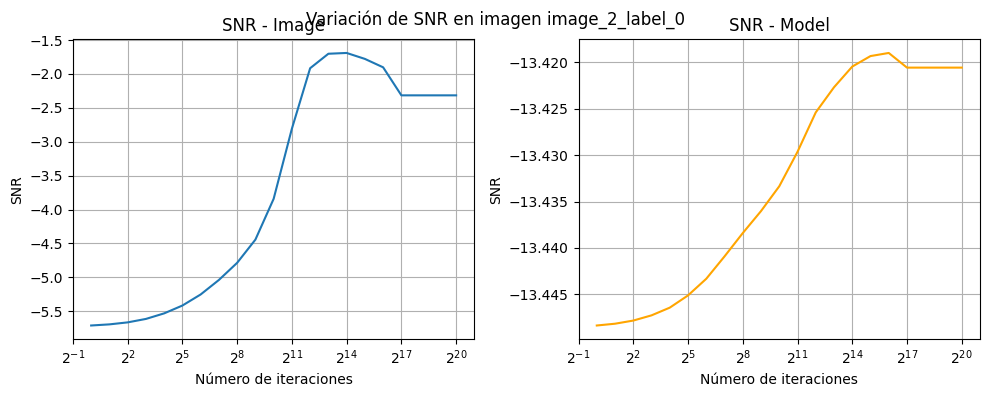

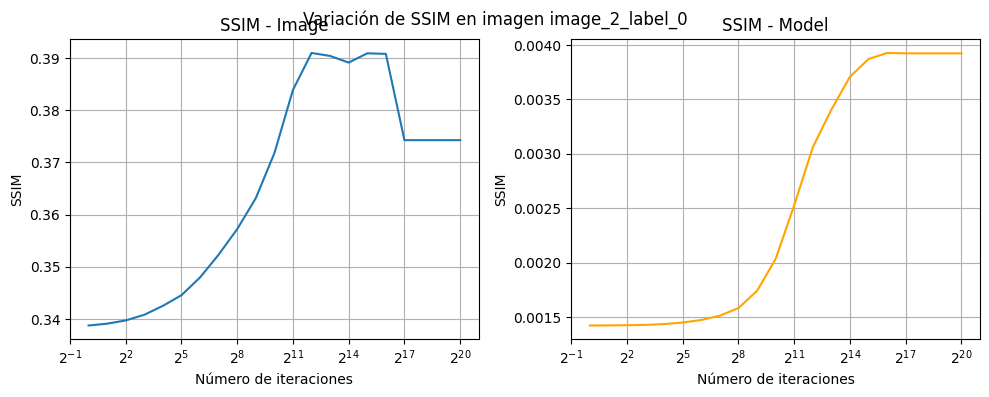

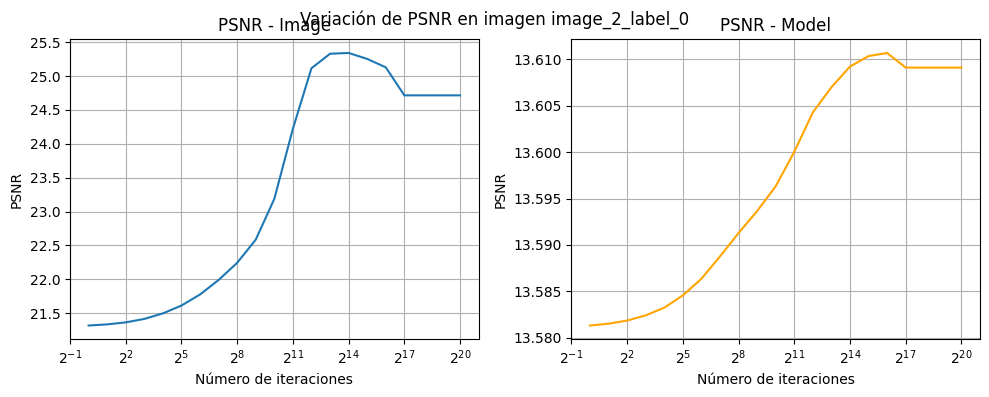

In [15]:
from matplotlib import pyplot as plt

for metric in ['snr', 'ssim', 'psnr']:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(df_image['niter'], df_image[metric], label='Image')
    plt.title(f'{metric.upper()} - Image')
    plt.xlabel('Número de iteraciones')
    plt.ylabel(metric.upper())
    plt.xscale('log', base=2)
    plt.grid(True)
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(df_model['niter'], df_model[metric], label='Model', color='orange')
    plt.title(f'{metric.upper()} - Model')
    plt.xlabel('Número de iteraciones')
    plt.ylabel(metric.upper())
    plt.xscale('log', base=2)
    plt.grid(True)
    plt.tight_layout()

    plt.suptitle(f'Variación de {metric.upper()} en imagen {file_folder}')
    plt.show()